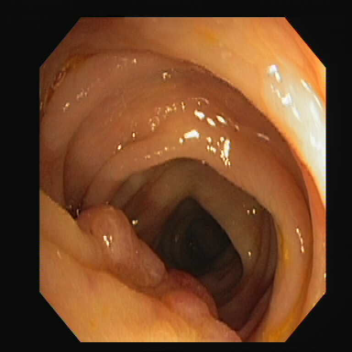

In [11]:
def eval_prioritization_strategy(prioritizer, experiment_name="MC Dropout"):
    wandb.init(project="Polyp Active Learning", name=experiment_name)
    
    train_indices = range(len(X_train))

    test_accuracies = []
    X_train_subset, y_train_subset = np.array([]), np.array([])

    CYCLES = 10
    for i in range(CYCLES):
        selected_indices = train_indices[:budget_size]
        train_indices = train_indices[budget_size:]
        # Define dataset for training
        X_train_subset = np.concatenate((X_train_subset, np.array(X_train)[selected_indices,...]))
        y_train_subset = np.concatenate((y_train_subset, np.array(y_train)[selected_indices,...]))
        
        train_dataset = ActiveDataset(X_train_subset, y_train_subset, transform=train_transform)
        train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=8, pin_memory=True, prefetch_factor=8)
        
        # Define unlabeled dataset for training
        X_unlabeled_subset = np.array(X_train)[train_indices,...]
        y_unlabeled_subset = np.array(y_train)[train_indices,...]
        
        unlabeled_dataset = ActiveDataset(X_unlabeled_subset, y_unlabeled_subset, transform=val_transform)
        unlabeled_dataloader = DataLoader(unlabeled_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)
        
        # Init model from scratch 
        model = ActiveSegmentationModel("FPN", "densenet169", in_channels=3, out_classes=1, labeled_dataloader=train_dataloader)

        # Training model from scratch
        trainer = pl.Trainer(accelerator="gpu", devices=[0], max_epochs=50)
        trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)
        
        datasets = os.listdir('TestDataset/')
        for dataset in datasets:
            # Test model 
            test_result = trainer.test(dataloaders=test_dataloader, verbose=False)
            iou = test_result[0]['test/per_image_iou']
            dice = 2*iou / (1 + iou)
            wandb.log({f'{dataset}_dice': dice, 'num_sample' : (i+1)*budget_size})
            
        # Test model 
        test_accuracies.append(iou)
        
        print('Training data size of %d => per_image_iou %f' % (X_train_subset.shape[0], iou))
        predictions = get_predictions(model, unlabeled_dataloader)
        # Select next train index
        train_indices = prioritizer(train_indices, predictions, i)
        # Clear cached cuda 
        torch.cuda.empty_cache()
        # Delete variables
        del model, train_dataset, train_dataloader, unlabeled_dataset, unlabeled_dataloader, predictions

    wandb.finish(quiet=False)

    # return test_accuracies

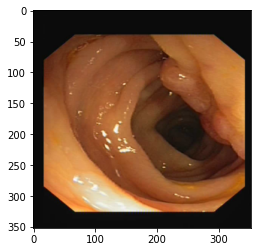

In [13]:
test1 = rearrange(np_img, 'h w c -> w h c')
plt.imshow(test1)

In [22]:
compose = [img]*4
compose = np.stack(compose, axis=0)
print(compose.shape)
test_compose = rearrange(compose, 'b h w c -> h (b w) c')

(4, 352, 352, 3)


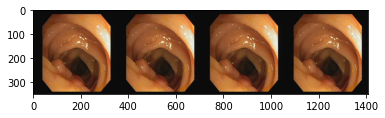

In [23]:
plt.imshow(test_compose)

In [34]:
test_2 = rearrange(compose, '(b1 b2) h w c -> (b1 h) (b2 w) c', b1=2)

In [35]:
test_2.shape

(704, 704, 3)

In [32]:
compose.shape

(4, 352, 352, 3)

In [30]:
test = compose.reshape(2*352, 2*352, -1)

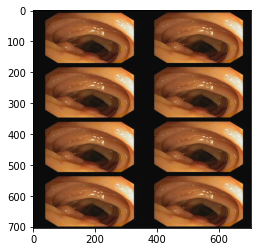

In [31]:
plt.imshow(test)